# Spread rate choice

The goal of the notebook is to explore different ways to compute a spread rate of the COVID-19 for a given country using the cumulative time series of confirmed cases.

This spread rate will then be used to compare the evolution of the COVID-19 in different countries with the position, climate and urbanization of the countries.

## Plotting confirmed cases

Before choosing between different spread rate computation methods, let's plot the cumulative time series of confirmed cases for a few countries to visualize the tendency and the shape of the curves.

In [1]:
import pandas as pd


data = pd.read_csv('data/data.csv')
data = data.drop(columns=['Latitude', 'Longitude', 'Urban Population', 'Total Population', 'Mortality Rate', 'Mean temperature', 'Climate'])

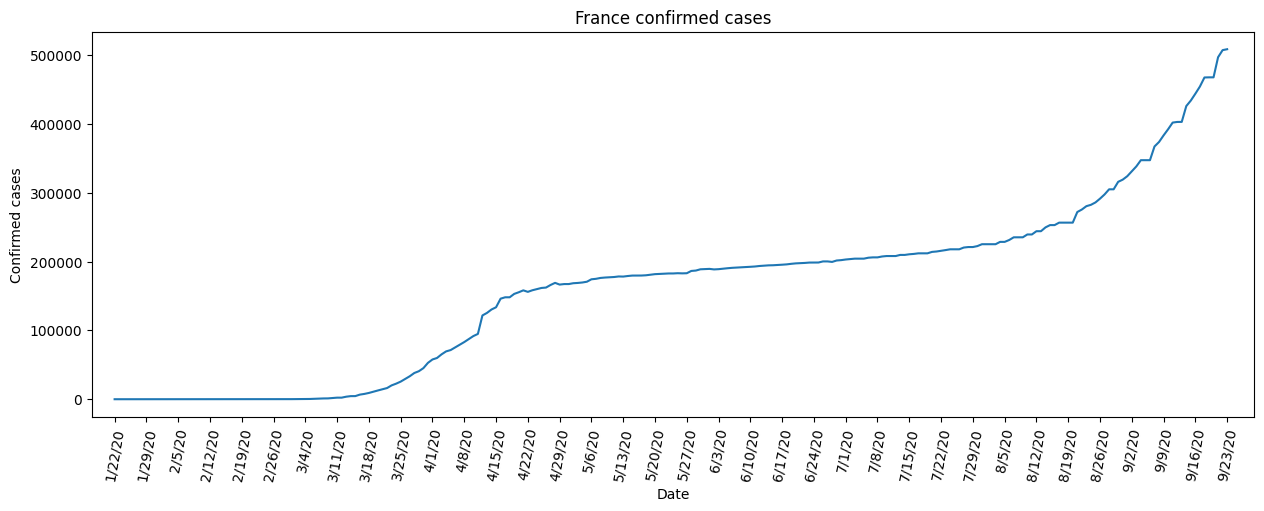

In [35]:
import matplotlib.pyplot as plt


country = 'France'

country_data = data[data['Country'] == country]
country_data = country_data.drop(columns=['Country'])

x = country_data.columns
y = country_data.values[0]

plt.figure(figsize=(15, 5))
plt.plot(x, y)
plt.title(f'{country} confirmed cases')
plt.xlim(-5, len(x) + 5)
plt.xlabel('Date')
plt.ylabel('Confirmed cases')
plt.xticks(rotation=80)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(7))
plt.show()